In [2]:
import bempp.api
from bempp.api.assembly.blocked_operator import BlockedOperator
import math
import numpy as np
import scipy 
import cmath
from numba import objmode
from numpy.linalg import slogdet
from bempp.api.operators.far_field import helmholtz as helmholtz_farfield
import matplotlib.pyplot as plt
bempp.core.opencl_kernels.set_default_device(0,0)

In [2]:
wavenumber = 0.4
d = [1,0,0]
deg = 5

In [3]:
def normalized_spherical_harmonics(p, q, x):
    """Spherical Harmonic function of degree q"""
    azimuth = np.arctan2(x[1],x[0])
    polar = np.arccos(x[2]/np.linalg.norm(x))
    if p >= 0:
        return ((-1)**p) * scipy.special.sph_harm(p,q,azimuth,polar)
    else:
        return scipy.special.sph_harm(-p,q,azimuth,polar)*np.exp(1j*2*p*azimuth)

def spherical_bessel_function(q,x):
    """Spherical Bessel function of degree q"""
    r = np.linalg.norm(x)
    return np.sqrt(np.pi/(2*wavenumber*r))*scipy.special.jv(q+0.5, wavenumber*r)

def regular_spherical_wavefunctions(p,q,x):
    """Regular Spherical Wavefunction"""
    return spherical_bessel_function(q,x)*normalized_spherical_harmonics(p,q,x)

def coeff_sph_expansion(p,q):
    """Analytical formula of the coefficients of the spherical expansions of plane waves"""
    coeff = 4*np.pi*(1j)**q*normalized_spherical_harmonics(-p,q,d)/(-1)**(abs(p))
    return coeff

In [4]:
two_branches = bempp.api.import_grid('6branches.msh')
space_two_branches = bempp.api.function_space(two_branches,'P',1)

In [5]:
for h in [0.2, 0.15, 0.1, 0.05]:
    
    unit_sphere = bempp.api.shapes.sphere(r = 1, origin=(0,0,0), h = h)
    vert_unit_sphere = unit_sphere.vertices
    space_unit_sphere = bempp.api.function_space(unit_sphere, 'P', 1)
    
    eta = wavenumber

    identity2 = bempp.api.operators.boundary.sparse.identity(space_two_branches, space_two_branches,space_two_branches)
    slp2 = bempp.api.operators.boundary.helmholtz.single_layer(space_two_branches,space_two_branches,space_two_branches,wavenumber)
    dlp2 = bempp.api.operators.boundary.helmholtz.double_layer(space_two_branches,space_two_branches,space_two_branches,wavenumber)
    slp_far2 = helmholtz_farfield.single_layer(space_two_branches, vert_unit_sphere, wavenumber)
    dlp_far2 = helmholtz_farfield.double_layer(space_two_branches, vert_unit_sphere,wavenumber)

    lhs2 = 0.5 * identity2 + dlp2 - 1j* eta *slp2
    
    sph_harm_coeff = []
    slp_far_field_coeff = []
    for q in range(deg+1):
        for p in range(-q,q+1):
            @bempp.api.complex_callable
            def sph_harm(x,n,domain_index,result):
                with objmode():
                    result[0] = normalized_spherical_harmonics(p,q,x)
            sph_harm_grid = bempp.api.GridFunction(space_unit_sphere,fun = sph_harm)
            sph_harm_coeff.append(np.conj(sph_harm_grid.coefficients)/((-1j)**(q+1)))

            @bempp.api.complex_callable
            def dirichlet_fun(x,n,domain_index,result):
                    with objmode():
                        result[0] = - regular_spherical_wavefunctions(p,q,x)

            rhs_fun = bempp.api.GridFunction(space_two_branches, fun = dirichlet_fun)
            field, info = bempp.api.linalg.gmres(lhs2, rhs_fun, tol=1E-5)
            slp_far_field_coeff.append(dlp_far2.evaluate(field) - 1j * eta * slp_far2.evaluate(field))

    mass_mat = bempp.api.operators.boundary.sparse.identity(space_unit_sphere,space_unit_sphere,space_unit_sphere).weak_form().A

    T_matrix = np.zeros(((deg+1)**2,(deg+1)**2),dtype = complex)
    for i in range((deg+1)**2):
        for j in range((deg+1)**2):
            T_matrix[i,j] = (slp_far_field_coeff[j] @ mass_mat @ sph_harm_coeff[i])*wavenumber

    coeff_inc = []
    for q in range(deg+1):
        for p in range(-q, q+1):
            coeff_inc.append(coeff_sph_expansion(p,q))

    coeff_sca = T_matrix @ coeff_inc

    S_matrix = np.identity(T_matrix.shape[0]) + 2 * T_matrix
    logdet = np.log(np.linalg.det(S_matrix))

    print(h, logdet)

0.2 (0.00012745822277429155-0.5714200291847987j)
0.15 (0.0006231317393604743-0.5734558098349501j)
0.1 (0.0009205569433774149-0.5746712898784768j)
0.05 (0.0011318642883968385-0.5755262307374039j)


In [ ]:
real_axis_d1 = [0.00012745822277429155, 0.0006231317393604743, 0.0009205569433774149, 0.0011318642883968385]
imag_axis_d1 = [-0.5714200291847987, -0.5734558098349501, -0.5746712898784768, -0.5755262307374039]

In [ ]:
plt.yscale('symlog')
plt.xscale('symlog')
plt.plot(real_axis_d1,imag_axis_d1,'*-')
plt.xlabel('Real part of logdet',fontsize = 15)
plt.ylabel('Imaginary part of logdet',fontsize = 15)
plt.title('logdet of S-matrix , deg = 5',fontsize = 15)
plt.savefig('six branches S matrix logdet.pdf',bbox_inches='tight')

In [6]:
h1 = 0.00012745822277429155-0.5714200291847987*1j
h2 = 0.0006231317393604743-0.5734558098349501*1j
h3 = 0.0009205569433774149-0.5746712898784768*1j
h4 = 0.0011318642883968385-0.5755262307374039*1j

In [7]:
err1 = np.linalg.norm(h1 - h4) /np.linalg.norm(h4)
err2 = np.linalg.norm(h2 - h4) /np.linalg.norm(h4)
err3 = np.linalg.norm(h3 - h4) /np.linalg.norm(h4)

Text(0.5, 1.0, 'relative error of logdet of S-matrix, deg = 5')

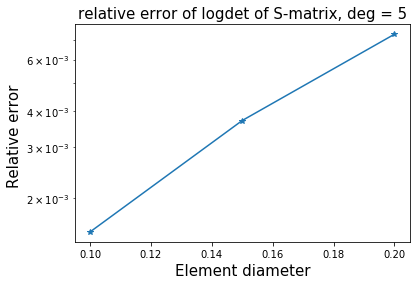

In [8]:
x_axis = [0.2, 0.15, 0.1]
y_axis = [err1, err2, err3]
plt.semilogy(x_axis,y_axis, '*-')
plt.xlabel('Element diameter',fontsize = 15)
plt.ylabel('Relative error ',fontsize = 15)
plt.title('relative error of logdet of S-matrix, deg = 5',fontsize = 15)

In [5]:
err1

0.007294033727240611